In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import sys
import os

# Add parent directory to path to allow importing modules
# Get the notebook's directory using a more reliable method
notebook_dir = Path(os.getcwd())
# Assuming notebook is run from strategy/ablations/forecaster/notebooks/
# We need to add strategy/ to the path
strategy_dir = notebook_dir.parent.parent.parent if 'notebooks' in str(notebook_dir) else notebook_dir.parent.parent

if str(strategy_dir) not in sys.path:
    sys.path.insert(0, str(strategy_dir))

print(f"Added to sys.path: {strategy_dir}")

from ablations.significance_tests import iterative_compare_models_per_metric, prepare_data

%matplotlib inline
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)

Added to sys.path: /lambda/nfs/negoformer/Negolog-RL


In [2]:
# Configuration
TARGET_DOMAINS = ['Domain5', 'Domain15', 'Domain30', 'Domain37', 'Domain43', 'Domain46', 'Domain57', 'Domain61']
print(f"Filtering for {len(TARGET_DOMAINS)} target domains: {TARGET_DOMAINS}")

# File Paths
# Loading 'oracle_baseline' for Toto to ensure we get the pure Oracle mode runs
paths = {
    'Toto': Path("/home/ubuntu/negoformer/Negolog-RL/ablations/forecaster/pickles/baseline_vs_zero_shot/toto.pkl"),
    'Chronos': Path("/home/ubuntu/negoformer/Negolog-RL/ablations/forecaster/pickles/baseline_vs_zero_shot/chronos.pkl"),
    'Baselines': Path("/home/ubuntu/negoformer/Negolog-RL/ablations/forecaster/pickles/baseline_vs_zero_shot/baseline.pkl")
}

# Load Raw Data
raw_data = {}
for key, path in paths.items():
    try:
        with open(path, 'rb') as f:
            raw_data[key] = pickle.load(f)
        print(f"Loaded {key} from {path}")
    except FileNotFoundError:
        # Fallback for Toto if baseline file missing, try target
        if key == 'Toto':
            try:
                alt_path = Path("forecaster_ablation_oracle_target.pkl")
                with open(alt_path, 'rb') as f:
                    raw_data[key] = pickle.load(f)
                print(f"Loaded {key} from {alt_path} (fallback)")
            except FileNotFoundError:
                 print(f"Warning: {path} and {alt_path} not found. Skipping {key}.")
        else:
            print(f"Warning: {path} not found. Skipping {key}.")

Filtering for 8 target domains: ['Domain5', 'Domain15', 'Domain30', 'Domain37', 'Domain43', 'Domain46', 'Domain57', 'Domain61']
Loaded Toto from /home/ubuntu/negoformer/Negolog-RL/ablations/forecaster/pickles/baseline_vs_zero_shot/toto.pkl
Loaded Chronos from /home/ubuntu/negoformer/Negolog-RL/ablations/forecaster/pickles/baseline_vs_zero_shot/chronos.pkl
Loaded Baselines from /home/ubuntu/negoformer/Negolog-RL/ablations/forecaster/pickles/baseline_vs_zero_shot/baseline.pkl


In [3]:
def aggregate_filtered_rounds(all_results, mode_key_filter=None):
    """
    Aggregates round-by-round metrics from raw session results,
    filtering only for TARGET_DOMAINS and specific mode keys.
    """
    aggregated = {} # {Round: {rmse: [], mape: [], crps: [], mase: []}}
    
    # all_results structure: {ModeName: [List of Session Dicts]}
    for mode, sessions in all_results.items():
        # Strict Mode Filtering
        if mode_key_filter:
            if mode not in mode_key_filter:
                continue
        # If no filter provided, fallback to checking for 'Oracle' (optional, but safer to be explicit)
        elif 'Oracle' not in mode:
             continue

        print(f"  Processing mode: {mode} ({len(sessions)} total sessions)")
        
        valid_sessions_count = 0
        
        for session in sessions:
            # DOMAIN FILTERING
            domain = session.get('domain')
            normalized_domain = domain if 'Domain' in str(domain) else f"Domain{domain}"
            
            if normalized_domain not in TARGET_DOMAINS:
                continue
            
            valid_sessions_count += 1
            
            # Aggregate Rounds
            if 'round_evaluations' in session:
                for round_eval in session['round_evaluations']:
                    r = round_eval['round']
                    if r not in aggregated:
                        aggregated[r] = {'rmse': [], 'mape': [], 'crps': [], 'mase': []}
                    
                    # Aggregate all metrics
                    for metric in ['rmse', 'mape', 'crps', 'mase']:
                        if metric in round_eval:
                            val = round_eval[metric]
                            if val is not None and not np.isnan(val):
                                aggregated[r][metric].append(val)
                             
        print(f"    -> Included {valid_sessions_count} sessions.")
        
    return aggregated

def get_results_list(data_dict):
    """Helper to retrieve the list of session results regardless of key name."""
    if 'all_mode_results' in data_dict:
        return data_dict['all_mode_results']
    if 'all_results' in data_dict:
        return data_dict['all_results']
    return None

In [ ]:
# Build Final Dataset using Filtering with Intersection
master_data = {}

# Helper to generate a unique key for each session
def get_session_key(s):
    # Use domain + filename as unique identifier
    # Note: filename in Baselines might include full path or just basename
    # We'll use basename of filename if possible, or just concat
    raw_fname = s.get('filename','')
    fname = str(Path(raw_fname).name) if raw_fname else ''
    return f"{s.get('domain','')}::{fname}"

# 1. First, load Baselines to define the "Valid Set" (since it's the most restrictive)
valid_keys = set()
if 'Baselines' in raw_data:
    print("\n--- Processing Baselines (Defining Valid Set) ---")
    src = get_results_list(raw_data['Baselines'])
    if src:
        # Check keys for PatchTST/LSTM
        baseline_sessions = []
        if 'Oracle_PatchTST' in src:
             baseline_sessions = src['Oracle_PatchTST']
             res = aggregate_filtered_rounds(src, mode_key_filter=['Oracle_PatchTST'])
             master_data['PatchTST'] = res
        elif 'PatchTST' in src:
             baseline_sessions = src['PatchTST']
             res = aggregate_filtered_rounds(src, mode_key_filter=['PatchTST'])
             master_data['PatchTST'] = res
             
        # Also process LSTM (add to master_data, keys should be same set)
        if 'Oracle_LSTM' in src:
             res = aggregate_filtered_rounds(src, mode_key_filter=['Oracle_LSTM'])
             master_data['LSTM'] = res
        elif 'LSTM' in src:
             res = aggregate_filtered_rounds(src, mode_key_filter=['LSTM'])
             master_data['LSTM'] = res
             
        # Build Valid Key Set from the sessions that were actually evaluated
        # We check both if available, or just the one used for baseline_sessions
        for s in baseline_sessions:
            if 'round_evaluations' in s and len(s['round_evaluations']) > 0:
                valid_keys.add(get_session_key(s))
                
        print(f"Defined valid set of {len(valid_keys)} sessions based on NeuralForecast results intersection.")

# 2. Toto (Filtered by Valid Set)
if 'Toto' in raw_data:
    print("\n--- Processing Toto ---")
    src = get_results_list(raw_data['Toto'])
    if src:
        # Filter source list before aggregation
        filtered_src = {}
        for mode, sessions in src.items():
            if 'Oracle' not in mode: continue
            
            # Keep only sessions in valid_keys
            # Filter by matching key
            kept_sessions = []
            for s in sessions:
                if get_session_key(s) in valid_keys:
                    kept_sessions.append(s)
                    
            filtered_src[mode] = kept_sessions
            print(f"  Toto {mode}: Filtered {len(sessions)} -> {len(kept_sessions)} sessions based on NeuralForecast availability")
            
        res = aggregate_filtered_rounds(filtered_src, mode_key_filter=['Oracle'])
        if res:
            master_data['Toto'] = res

# 3. Chronos (Filtered by Valid Set)
if 'Chronos' in raw_data:
    print("\n--- Processing Chronos ---")
    src = get_results_list(raw_data['Chronos'])
    if src:
        filtered_src = {}
        for mode, sessions in src.items():
            if 'Oracle' not in mode: continue
            
            # Keep only sessions in valid_keys
            kept_sessions = []
            for s in sessions:
                if get_session_key(s) in valid_keys:
                    kept_sessions.append(s)
            
            filtered_src[mode] = kept_sessions
            print(f"  Chronos {mode}: Filtered {len(sessions)} -> {len(kept_sessions)} sessions based on NeuralForecast availability")

        res = aggregate_filtered_rounds(filtered_src, mode_key_filter=['Oracle'])
        if res:
             master_data['Chronos'] = res

In [ ]:
# Plotting Functions
colors = {
    'Toto': '#2ca02c',     # Green
    'Chronos': '#d62728',  # Red
    'PatchTST': '#1f77b4', # Blue
    'LSTM': '#7f7f7f'      # Gray
}

def plot_metric_line(data, metric='rmse', ylabel='RMSE', title_suffix=''):
    if not data:
        print(f"No data to plot {metric} line chart!")
        return

    plt.figure(figsize=(12, 7))
    
    for name, rounds_dict in data.items():
        rounds = sorted(rounds_dict.keys())
        means = []
        valid_rounds = []
        
        for r in rounds:
            vals = rounds_dict[r][metric]
            if vals:
                means.append(np.mean(vals))
                valid_rounds.append(r)
        
        if valid_rounds:
             plt.plot(valid_rounds, means, label=name, color=colors.get(name, 'black'), 
                      linewidth=2.5, marker='o', markersize=5)
    
    plt.xlabel("Round", fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_metric_violin(data, metric='rmse', ylabel='RMSE', ylim=None):
    if not data:
        print(f"No data to plot {metric} violin chart!")
        return

    plot_data = []
    for name, rounds_dict in data.items():
        all_vals = []
        for r in rounds_dict:
            all_vals.extend(rounds_dict[r][metric])
        
        for v in all_vals:
            plot_data.append({'Model': name, ylabel: v})
    
    if not plot_data:
        print(f"No valid {metric} values found for violin plot.")
        return
            
    df = pd.DataFrame(plot_data)
    plt.figure(figsize=(12, 7))
    sns.violinplot(data=df, x='Model', y=ylabel, palette=colors, cut=0)
    plt.show()

# Legacy functions for backwards compatibility
def plot_rmse_line(data):
    plot_metric_line(data, metric='rmse', ylabel='RMSE')

def plot_violin(data):
    plot_metric_violin(data, metric='rmse', ylabel='RMSE', ylim=(0, 0.5))

In [6]:
print("\n--- Prediction Counts (Total Filtered Data Points) ---")
for name, rounds_dict in master_data.items():
    count = sum(len(rounds_dict[r]['rmse']) for r in rounds_dict)
    print(f"{name}: {count} predictions")


--- Prediction Counts (Total Filtered Data Points) ---
PatchTST: 11886 predictions
LSTM: 12002 predictions
Toto (Oracle): 12571 predictions
Chronos: 12571 predictions


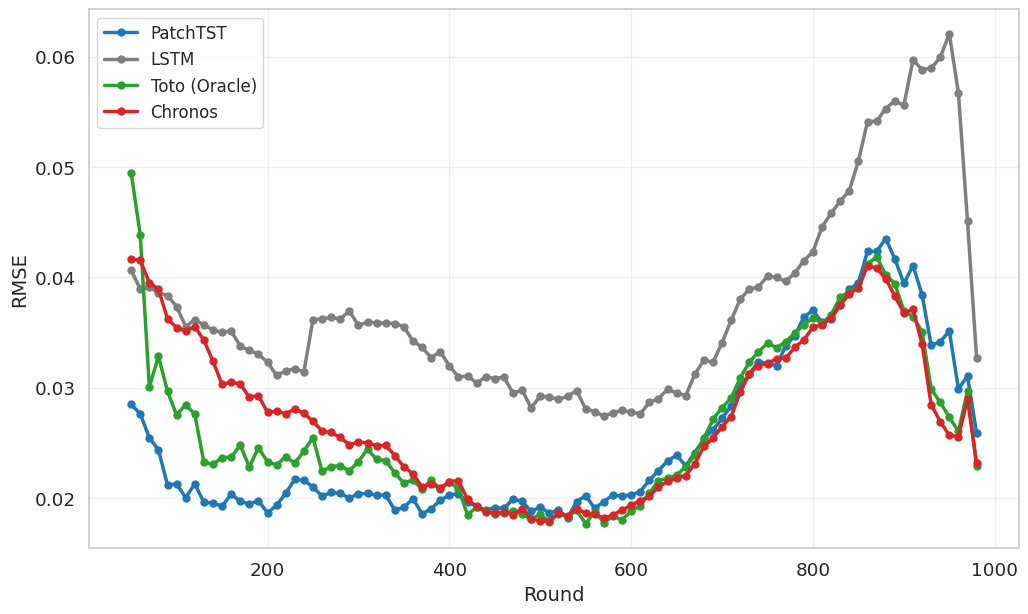

/tmp/ipykernel_3995/1882025708.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Model', y=ylabel, palette=colors, cut=0)


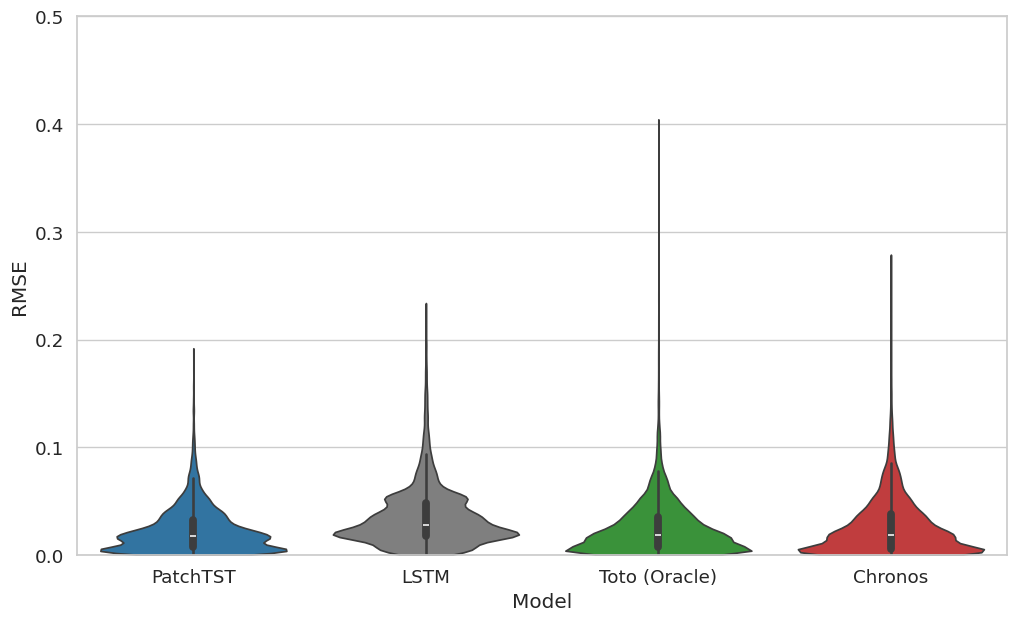

In [7]:
# RMSE Plots
plot_rmse_line(master_data)
plot_violin(master_data)

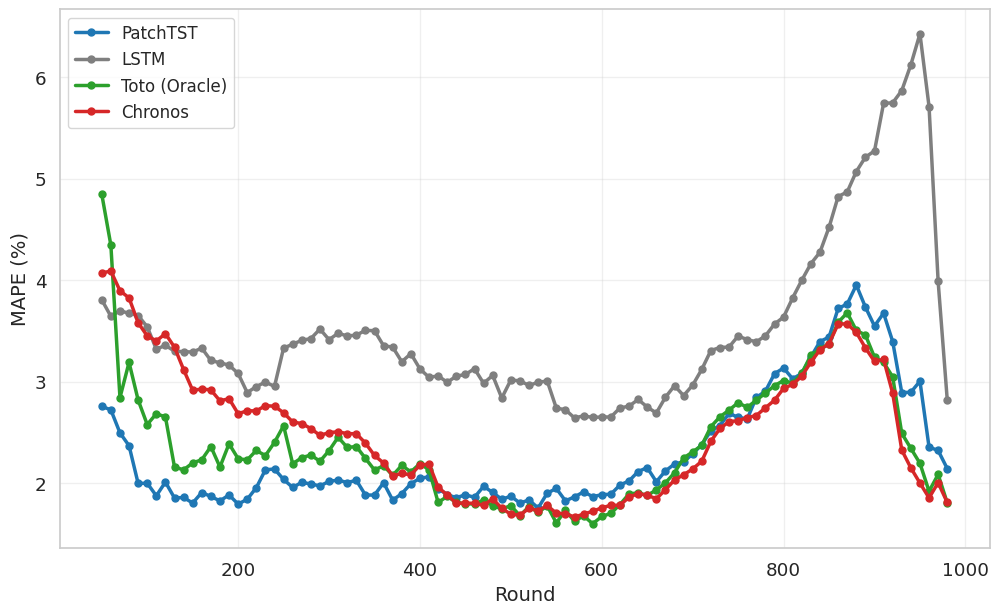

/tmp/ipykernel_3995/1882025708.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Model', y=ylabel, palette=colors, cut=0)


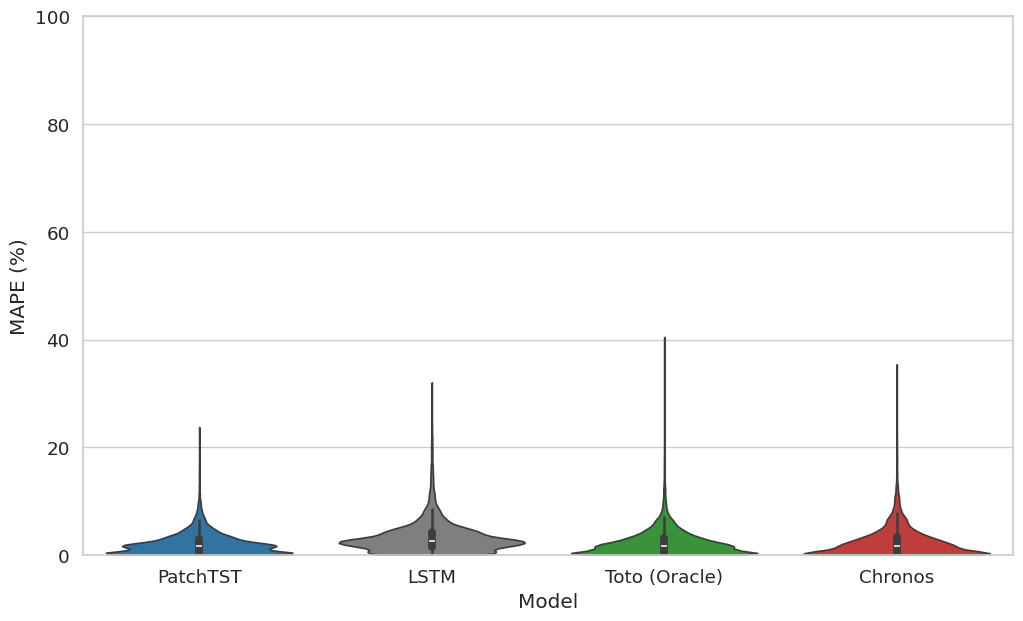

In [8]:
# MAPE Plots
plot_metric_line(master_data, metric='mape', ylabel='MAPE (%)')
plot_metric_violin(master_data, metric='mape', ylabel='MAPE (%)', ylim=(0, 100))

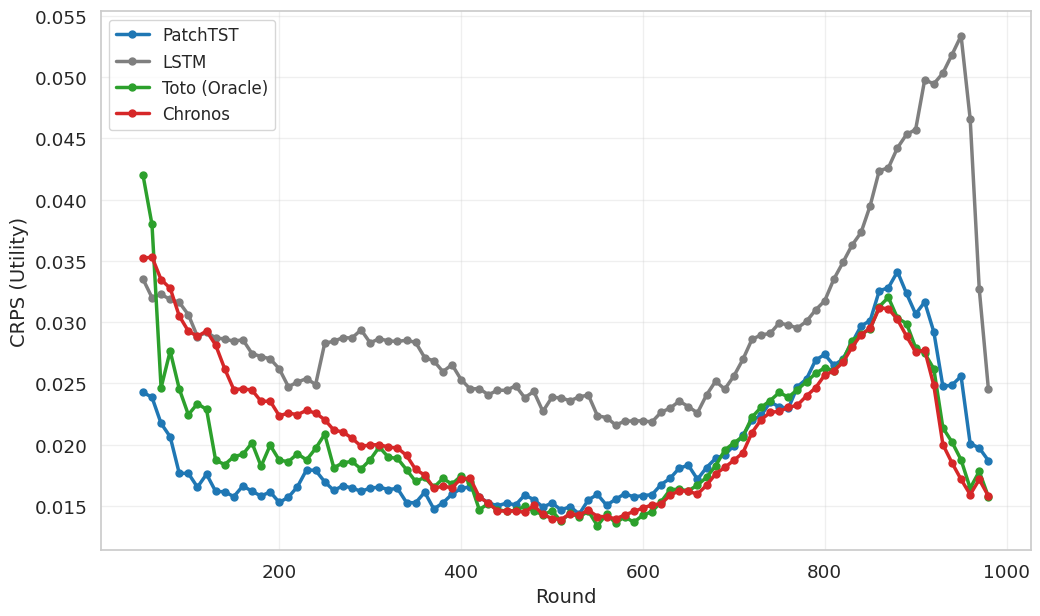

/tmp/ipykernel_3995/1882025708.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Model', y=ylabel, palette=colors, cut=0)


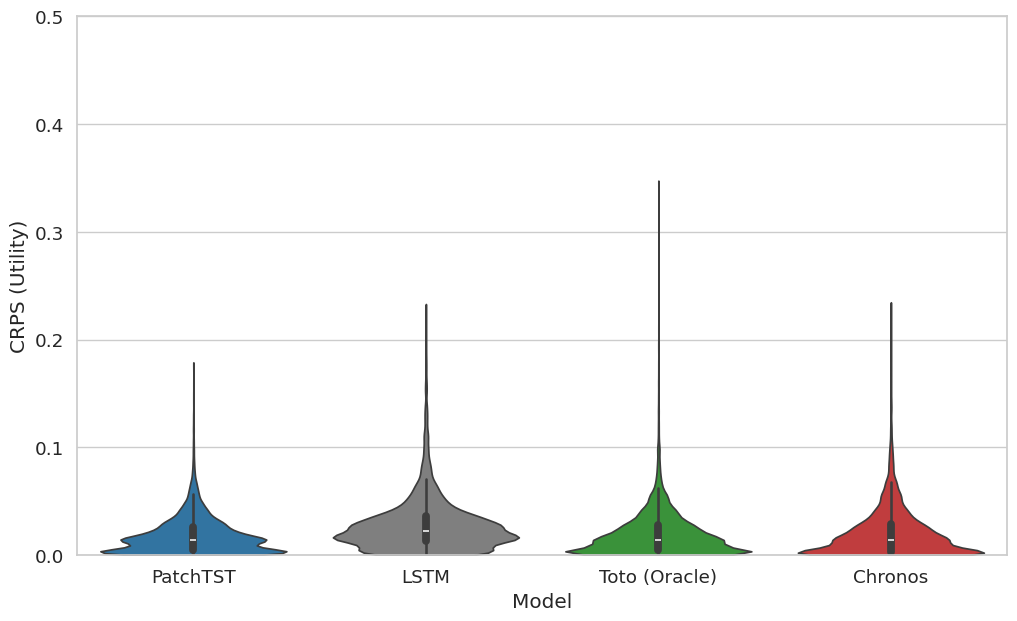

In [9]:
# CRPS Plots
plot_metric_line(master_data, metric='crps', ylabel='CRPS (Utility)')
plot_metric_violin(master_data, metric='crps', ylabel='CRPS (Utility)', ylim=(0, 0.5))

In [10]:
# Debug: Check MASE data availability
print("\n--- MASE Data Availability ---")
for name, rounds_dict in master_data.items():
    mase_counts = sum(len(rounds_dict[r]['mase']) for r in rounds_dict)
    rmse_counts = sum(len(rounds_dict[r]['rmse']) for r in rounds_dict)
    print(f"{name}:")
    print(f"  RMSE values: {rmse_counts}")
    print(f"  MASE values: {mase_counts}")
    
    # Sample some MASE values
    if mase_counts > 0:
        all_mase = []
        for r in rounds_dict:
            all_mase.extend(rounds_dict[r]['mase'])
        print(f"  MASE min/mean/max: {np.min(all_mase):.2f} / {np.mean(all_mase):.2f} / {np.max(all_mase):.2f}")
    else:
        print(f"  WARNING: No MASE values found!")
    print()


--- MASE Data Availability ---
PatchTST:
  RMSE values: 11886
  MASE values: 10980
  MASE min/mean/max: 0.04 / 10.20 / 497.39

LSTM:
  RMSE values: 12002
  MASE values: 11105
  MASE min/mean/max: 0.03 / 18.96 / 749.25

Toto (Oracle):
  RMSE values: 12571
  MASE values: 11614
  MASE min/mean/max: 0.03 / 12.03 / 605.70

Chronos:
  RMSE values: 12571
  MASE values: 11614
  MASE min/mean/max: 0.00 / 12.56 / 595.37



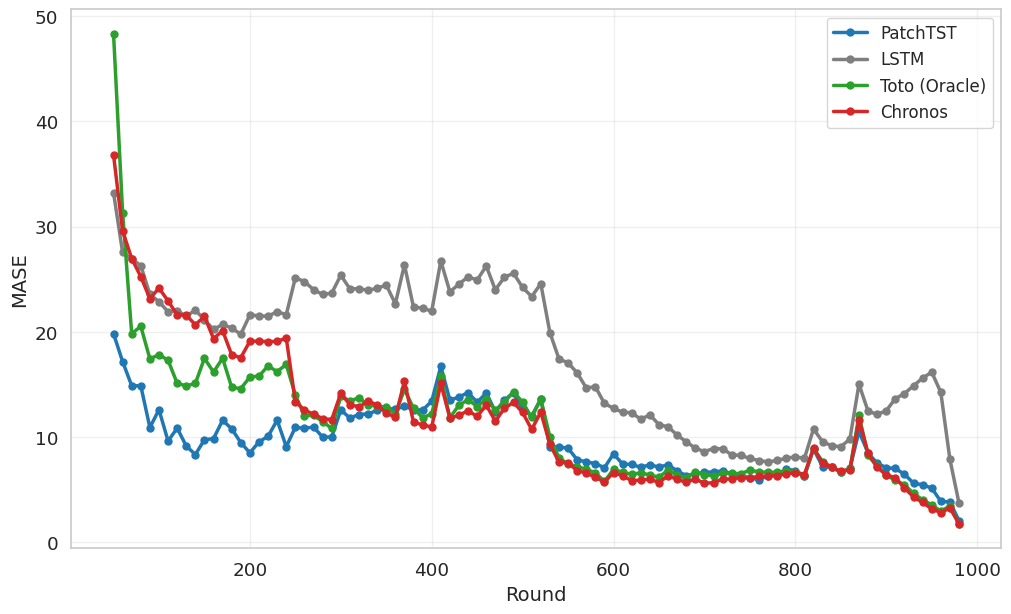

/tmp/ipykernel_3995/1882025708.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Model', y=ylabel, palette=colors, cut=0)


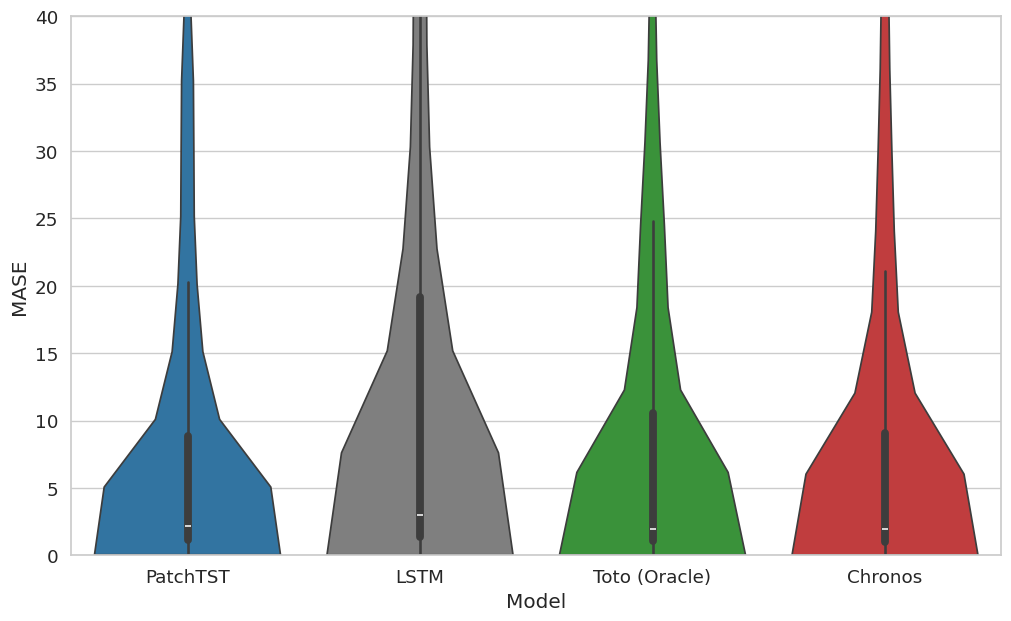

In [11]:
# MASE Plots
plot_metric_line(master_data, metric='mase', ylabel='MASE')
plot_metric_violin(master_data, metric='mase', ylabel='MASE', ylim=(0, 40))

In [ ]:
# Summary Statistics Table (Mean ± Std)
def create_summary_table(master_data):
    """Create a summary table showing mean ± std for each model across all metrics."""
    rows = []
    for model, rounds_dict in master_data.items():
        row = {'Model': model}
        for metric in ['rmse', 'mape', 'crps', 'mase']:
            all_vals = []
            for r in rounds_dict:
                all_vals.extend(rounds_dict[r][metric])
            row[metric.upper()] = f"{np.mean(all_vals):.4f} ± {np.std(all_vals):.4f}"
        rows.append(row)
    return pd.DataFrame(rows).set_index('Model')

summary_table = create_summary_table(master_data)
print("\n=== Model Comparison: Summary Statistics ===\n")
display(summary_table)

In [ ]:
# Statistical Significance Tests
def prepare_ratings_df(master_data):
    """Prepare data in the format expected by iterative_compare_models_per_metric.
    
    Values are negated because all metrics (RMSE, MAPE, CRPS, MASE) are 'lower is better',
    but the significance test framework expects 'higher is better'.
    """
    metrics = ['rmse', 'mape', 'crps', 'mase']
    data = {}

    for model, rounds_dict in master_data.items():
        data[model] = {}
        for metric in metrics:
            all_vals = []
            for r in rounds_dict:
                all_vals.extend(rounds_dict[r][metric])
            # Negate values: lower is better -> higher is better
            data[model][metric] = [-v for v in all_vals]

    # Create DataFrame with lists as values
    df = pd.DataFrame(data).T
    df.columns = metrics

    # Ensure equal length for paired tests (truncate to minimum per metric)
    for metric in metrics:
        min_len = min(len(df.loc[m, metric]) for m in df.index)
        for m in df.index:
            df.loc[m, metric] = df.loc[m, metric][:min_len]

    return df

# Prepare data and run significance tests
ratings_df = prepare_ratings_df(master_data)
print("\n=== Statistical Significance Tests ===\n")
print(f"Sample sizes per metric after alignment:")
for metric in ratings_df.columns:
    print(f"  {metric.upper()}: {len(ratings_df.iloc[0][metric])} samples")
print()

significance_results = iterative_compare_models_per_metric(ratings_df)
display(significance_results)